# Assignment : Spam Filter
## Description
This assignment is near-final modulo some small adjustments (6 Nov '16)
In this assignment, you will discover that in many practical machine learning problems implementing the learning algorithm is often only a small part of the overall system. Thus to get a high mark for this assignment you need to implement any of the more advanced classification techniques or clever pre-processing methods. You will find plenty of them on the internet. If you do not know where to look for them, ask Google ;-).

Here your task is to build the standard (i.e. multinomial) Naive Bayes text classifier described during the lectures. You should test your program using the automatic marking software (described below), so it is critically important that it follows the specifications in detail.

You will train your classifier on real-world e-mails, which you can download from here. Each training e-mail is stored in a separate file. The names of spam training e-mails start with spam, while the names of ham e-mails start with ham.

## Marking criteria

Part 1 (40%):
    - Your program classifies the testing set with an accuracy significantly higher than random within 30 minutes
    - Use very simple data preprocessing so that the emails can be read into the Naive Bayes (remove everything else other than words from emails)
    - Write simple Naive Bayes multinomial classifier or use an implementation from a library of your choice
    - Classify the data
    - Report your results with a metric (e.g. accuracy) and method (e.g. cross validation) of your choice
    - Choose a baseline and compare your classifier against it

Part 2 (30%):
    - Use some smart feature processing techniques to improve the classification results
    - Compare the classification results with and without these techniques
    - Analyse how the classification results depend on the parameters (if available) of chosen techniques
    - Compare (statistically) your results against any other algorithm of your choice (use can use any library); compare and contrast results, ensure fair comparison

Part 3 (30%):
    - Calibration (15%): calibrate Naive Bayes probabilities, such that they result in low mean squared error
    - Naive Bayes extension (15%): modify the algorithm in some interesting way (e.g. weighted Naive Bayes)
    

** Convert from .ipynb to .py : ** $ ipython nbconvert --to python filter.ipynb

** BeautifulSoup: ** $ pip install beautifulsoup4




In [1]:
# Import all necessary packages
import math
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import email
import nltk



import os, re




** Part 1 Filtering **

In [73]:

# Removes header from email if present

def get_body(msg):
    if isinstance(msg, str):
        return msg
    elif msg.is_multipart():
        payloads = ''
        for payload in msg.get_payload():
            # if payload.is_multipart(): ...
            payloads += ' ' + get_body(payload)
        return payloads
    else:
        return msg.get_payload()
    
    
# Returns text containing only words (lowercase)
def remove_extras(text):
    brackets = "\([^)]*\)"
    email_address = "([\w.-]+)@([\w.-]+)"
    web_address = "http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
    numbers = "\d+"
    alphanumeric = "([^\s\w]|_)+"
    whitespace = "\s+"

    text = re.sub(email_address, '', text)
    text = re.sub(web_address, '', text)
    text = re.sub(numbers, '', text)
    text = re.sub(alphanumeric, '', text)
    text = re.sub(whitespace, ' ', text).strip()
    text = text.lower() # Lowercase
    return text

def simple_html_filter(html_doc):

    soup = BeautifulSoup(str(html_doc), "html.parser")


    for script in soup(["script", "style"]):
        script.extract()    # rip it out
        
    text = soup.get_text()
    return text

def filter_stop_words(text):
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

def filter_part1(email): 
    message = get_body(email)
    message = simple_html_filter(message)
    message = remove_extras(message)
    return message


# ---------------------

# Example

with open('training_data/ham000.txt') as f:
    text_test = f.read()

msg = email.message_from_string(text_test)

filter_part1(msg)



u'you are receiving this email because you signed up to receive one of our free reports if you would prefer not to receive messages of this type please unsubscribe by following the instructions at the bottom of this message dear investor thank you again for requesting our free special report the one stock that keeps wall street buzzing we began the motley fool in with the idea that investors like you deserved better better than wall streets alltoooften biased research better than analysts who speak in secret codes allowing them to hedge or spin any recommendation and better than what passes for full financial disclosure in big business today given a level playing field we believe that regular folks like us and you can do quite well in the stock market why put trust in conflicted information from others when you could count on your own abilities and potentially blow the pros away more than two million people visit our foolcom web site each month we spend a great deal of time at foolcom 

In [74]:
# from email.header import decode_header
# def getheader(header_text, default="ascii"):
#     """Decode the specified header"""

#     headers = decode_header(header_text)
#     header_sections = [unicode(text, charset or default)
#                        for text, charset in headers]
#     return u"".join(header_sections)


# getheader(msg["from"])

In [100]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import SnowballStemmer 
from geoip import geolite2

def do_stemming(text):
    stemmed = ""
    for word in text.split():
#         stemmed += PorterStemmer().stem(word) + " "
        stemmed += LancasterStemmer().stem(word) + " "
    return stemmed

def simple_html_filter(html_doc):

    soup = BeautifulSoup(str(html_doc), "html.parser")

    for elem in soup(["script", "style"]):
        elem.extract()    # rip it out

    text = soup.get_text()
    return text


def get_source_country(email):
    ips = re.findall( r'[0-9]+(?:\.[0-9]+){3}', str(email) )

    if len(ips) > 0:
        match = geolite2.lookup(ips[0])
        if match:
            return str(match.country)

    return ''

def filter_part2(email):
    message = get_body(email)
    message = simple_html_filter(message)
    message = remove_extras(message)
    message = filter_stop_words(message)
    message = do_stemming(message)
    return message

# ---------------------

# Example

with open('training_data/spam014.txt') as f:
    text_test = f.read()

msg = email.message_from_string(text_test)

print(filter_part2(msg))

comply see not bottom mail wast money every singl mon hom mortg rat drop simply fil fre oblig form find much sav easy visit websit comply not mail sent comply stat fed law receiv mail address list prevy busy contact purchas list optin prevy busy contact gen internet address import list list address express desir remov fut mail remov request autom process within hour address process nev receiv market mail address us remov click send mailtosubjectremov 


read in all documents and convert to a bag of words

In [101]:
import glob
training_data = []
training_labels = []
training_label_names = ['ham', 'spam']
        
# ham
for filename in glob.glob('training_data/ham*.txt'):
    f = open(filename, 'r')
    training_data.append(f.read())
    training_labels.append(0)

# spam    
for filename in glob.glob('training_data/spam*.txt'):
    f = open(filename, 'r')
    training_data.append(f.read())
    training_labels.append(1)


In [102]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.base import BaseEstimator

class PreProcessor(BaseEstimator):
    def __init__(self, part_name):
        self.part_name = part_name
        
    def transform(self, X):
        out = []
        for item in X:
            if self.part_name == 'part1':
                data = filter_part1(email.message_from_string(item))
            elif self.part_name == 'part2':
                data = filter_part2(email.message_from_string(item))
            else:
                raise Exception('unknwon part name for PreProcessor') 
            out.append(data)
        return out

    def fit(self, X, y=None):
        return self

In [ ]:
clf_pipe_p1 = Pipeline([('preprocess', PreProcessor('part1')),
                    ('vect', CountVectorizer(decode_error='ignore')),
                    ('clf', MultinomialNB()),
])

Let's test using Stratified Cross Validation:

In [103]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score

k = 10
skf = StratifiedKFold(training_labels, n_folds=k)
acc_per_fold = []

for train_indices, test_indices in skf:
    clf = clf_pipe_p1.fit([training_data[i] for i in train_indices], [training_labels[i] for i in train_indices])
    predicted = clf.predict([training_data[i] for i in test_indices])
    acc_per_fold.append( accuracy_score([training_labels[i] for i in test_indices], predicted) )

print "Accuracy per fold:", acc_per_fold
print "Average accuracy:", np.mean(acc_per_fold)

Accuracy per fold: [0.95999999999999996, 0.97999999999999998, 0.90000000000000002, 0.97999999999999998, 0.92000000000000004, 1.0, 0.97999999999999998, 0.95999999999999996, 1.0, 1.0]
Average accuracy: 0.968


And we'll also test using a separate (large) batch of test data

In [104]:
import random
def pickTestData(count=1):
    labelsFile = open('testdata.label', 'r')
    labeling = labelsFile.readlines()
    random.shuffle(labeling)
    sample = labeling[0:count]
    return [(open('test_data/'+row.split()[1], 'r').read(), 1-int(row.split()[0])) for row in sample]

test_items = pickTestData(1000)

test_data = [i[0] for i in test_items]
test_labels = [item[1] for item in test_items]

In [138]:

from sklearn.naive_bayes import MultinomialNB
# we're using multinomial because it's most relevant for word counts

predicted = clf_pipe_p1.fit(training_data, training_labels).predict(test_data)

accuracy = accuracy_score(test_labels, predicted)

print "Accuracy against test data:", accuracy

Accuracy against test data: 0.838


In [135]:
%matplotlib inline

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Confusion matrix, without normalization
[[650  17]
 [145 188]]
Normalized confusion matrix
[[ 0.97  0.03]
 [ 0.44  0.56]]


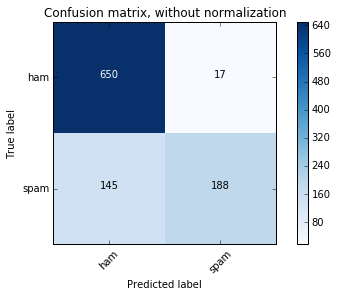

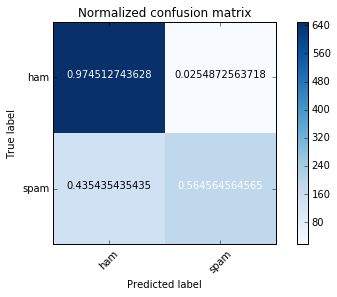

In [141]:

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['ham', 'spam'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['ham', 'spam'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [107]:
from sklearn import metrics
import pandas as pd
from ggplot import *

def plotRoc(ground_truths, predictions):
    fpr, tpr, _ = metrics.roc_curve(ground_truths, predictions)

    df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
    auc = metrics.auc(fpr,tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',
    label='AUC = %0.2f'% auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    return ggplot(df, aes(x='fpr', y='tpr')) +\
        geom_area(alpha=0.2) +\
        geom_line(aes(y='tpr')) +\
        ggtitle("ROC Curve w/ AUC=%s" % str(auc)) +\
        geom_abline(linetype='dashed')



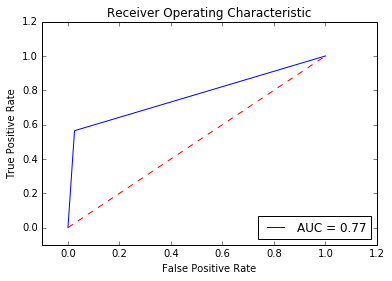

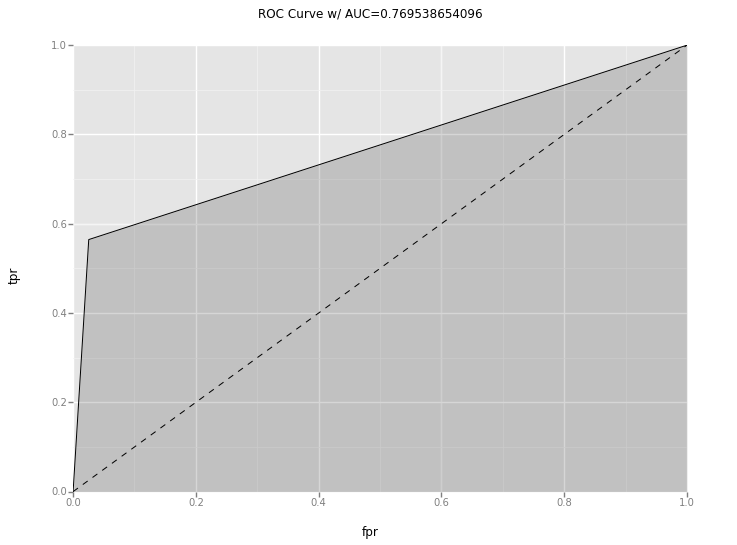

<ggplot: (290897885)>

In [108]:
plotRoc(test_labels, predicted)

we'll use a DummyClassifier as our baseline, in stratified cross validation:

In [109]:
from sklearn.dummy import DummyClassifier

clf_pipe_dummy = Pipeline([('preprocess', PreProcessor('part1')),
                     ('vect', CountVectorizer(decode_error='ignore')),
#                      ('tfidf', TfidfTransformer(use_idf=False)),
                     ('clf', DummyClassifier('uniform')),
])

In [110]:
k = 10
skf = StratifiedKFold(training_labels, n_folds=k)
acc_per_fold = []

for train_indices, test_indices in skf:
    dclf = clf_pipe_dummy.fit([training_data[i] for i in train_indices], [training_labels[i] for i in train_indices])
    predicted = dclf.predict([training_data[i] for i in test_indices])
    acc_per_fold.append( accuracy_score([training_labels[i] for i in test_indices], predicted) )

print "Baseline accuracy per fold:", acc_per_fold
print "Baseline average accuracy:", np.mean(acc_per_fold)

Baseline accuracy per fold: [0.28000000000000003, 0.5, 0.54000000000000004, 0.56000000000000005, 0.5, 0.40000000000000002, 0.44, 0.47999999999999998, 0.54000000000000004, 0.46000000000000002]
Baseline average accuracy: 0.47


and against our test data:

In [111]:
dummy_predicted = clf_pipe_dummy.fit(training_data, training_labels).predict(test_data)

dummy_accuracy = accuracy_score(test_labels, dummy_predicted)

print "Baseline accuracy against test data:", dummy_accuracy

Baseline accuracy against test data: 0.507


# Part 2

now we can do some more interesting things

In [115]:
clf_pipe_p2 = Pipeline([('preprocess', PreProcessor('part2')),
                     ('vect', CountVectorizer(decode_error='ignore', binary=True, max_features=10000)),
                     ('clf', MultinomialNB(alpha=1, fit_prior=False)),
])

In [116]:
k = 10
skf = StratifiedKFold(training_labels, n_folds=k)
acc_per_fold = []

for train_indices, test_indices in skf:
    clf = clf_pipe_p2.fit([training_data[i] for i in train_indices], [training_labels[i] for i in train_indices])
    predicted = clf.predict([training_data[i] for i in test_indices])
    acc_per_fold.append( accuracy_score([training_labels[i] for i in test_indices], predicted) )

print "Accuracy per fold:", acc_per_fold
print "Average accuracy:", np.mean(acc_per_fold)

Accuracy per fold: [0.93999999999999995, 0.97999999999999998, 0.95999999999999996, 1.0, 0.95999999999999996, 1.0, 0.97999999999999998, 0.95999999999999996, 0.93999999999999995, 0.97999999999999998]
Average accuracy: 0.97


In [142]:
predicted = clf_pipe_p2.fit(training_data, training_labels).predict(test_data)

accuracy = accuracy_score(test_labels, predicted)

print "Accuracy against test data:", accuracy

Accuracy against test data: 0.823


Confusion matrix, without normalization
[[663   4]
 [173 160]]
Normalized confusion matrix
[[ 0.99  0.01]
 [ 0.52  0.48]]


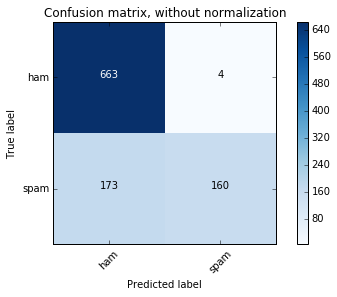

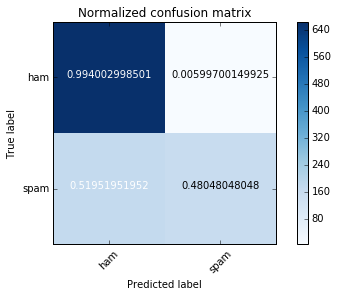

In [143]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=training_label_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=training_label_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

we need to compare our part 2 algorithm to another algorithm of our choice. We'll use an SVM.

SVM accuracy against test data: 0.787


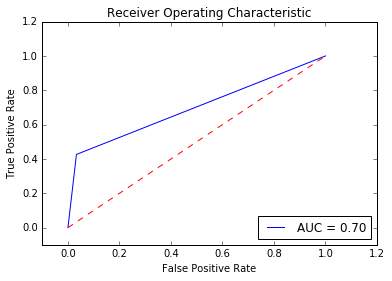

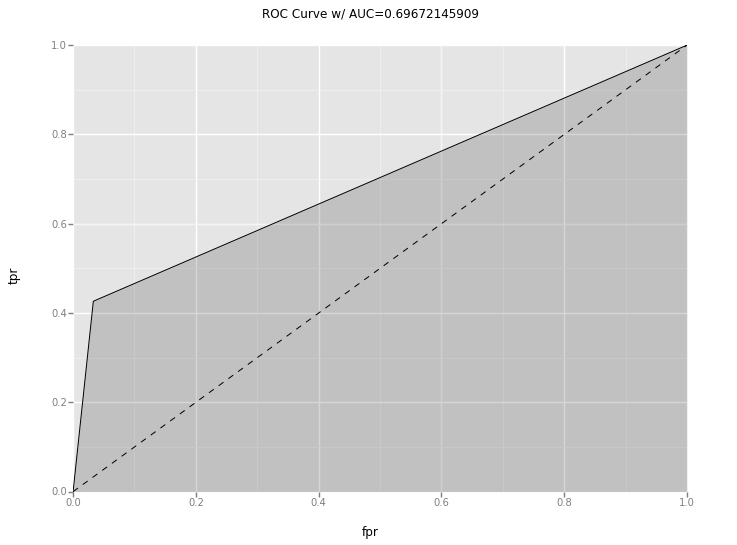

<ggplot: (293616149)>

In [113]:
from sklearn.linear_model import SGDClassifier
clf_pipe_svm = Pipeline([('preprocess', PreProcessor('part2')),
                    ('vect', CountVectorizer(decode_error='ignore')),
                    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, n_iter=5, random_state=42)),
])

predicted = clf_pipe_svm.fit(training_data, training_labels).predict(test_data)

accuracy = accuracy_score(test_labels, predicted)

print "SVM accuracy against test data:", accuracy

plotRoc(test_labels, predicted)

best SVM tuned parameters

In [114]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'clf__alpha': (1e-2, 1e-3),
}

gs_clf = GridSearchCV(clf_pipe_svm, parameters, n_jobs=-1)

gs_clf = gs_clf.fit(training_data, training_labels)

print "Best score:", gs_clf.best_score_

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

NameError: name 'svm_clf' is not defined

I want to tune the part2 parameters to see what the best value can be

In [25]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
              'vect__binary': (True, False),
              'vect__max_features': [None, 10000],
              'vect__stop_words': ('english', None),
              'clf__alpha': (0, 1),
              'clf__fit_prior': (False, True)
}

gs_clf = GridSearchCV(clf_pipe_p2, parameters, n_jobs=-1)

gs_clf = gs_clf.fit(training_data, training_labels)

print "Best score:", gs_clf.best_score_

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

Best score: 0.982
clf__alpha: 1
clf__fit_prior: False
vect__binary: True
vect__max_features: 10000
vect__ngram_range: (1, 1)
vect__stop_words: None


/usr/local/lib/python2.7/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/usr/local/lib/python2.7/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/usr/local/lib/python2.7/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/usr/local/lib/python2.7/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/usr/local/lib/python2.7/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/usr/local/lib/python2.7/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) 